In [1]:
import numpy as np
import pandas as pd
import os
import ast
import nltk
import functools
import re
import json
import statistics
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

In [2]:
WORD_COUNTS_NAME = 'word_counts'
WORD_COUNTS_LIST_NAME = 'word_counts_list'
TOTAL_NAME = 'total_words'
COMMENTS_COLUMN = 'comments'
FREQUENCY_NAME = 'frequency'
MAGNIFY_LIST = ['too', 'very', 'that', 'so', 'as']
NEGATIVE_LIST = ['not', 'aren\'t', 'isn\'t', 'wasn\'t', 'didn\'t']
WORD_CATEGORIES = {
    'rigor': ['easy', 'hard', 'rigorous'],
    'subject': ['math', 'computer', 'english', 'history', 'economics'],
    'activity': ['read', 'write', 'listen', 'watch', 'code', 'proof']
}
IMPORTANT_WORDS = reduce(lambda x, y: x + y, WORD_CATEGORIES.values())

In [4]:
# HIGH MEMORY: Don't load unless you have to
with open('data/overall_list.json', 'r') as f:
    ALL_WORKLOAD_LIST = json.load(f)
    
# TODO: Finish this for other metrics
# with open('overall_list.json', 'r') as f:
#     ALL_RECOMMEND_LIST = json.load(f)

In [28]:
'''Fixes the fact that some zeros are encoded as empty list'''
def fix_list(x):
    try:
        return int(x)
    except:
        return 0
    
df = pd.read_csv('raw_data/final.csv').drop('Unnamed: 0', 1)
df.enrollment = df.enrollment.apply(fix_list)

In [8]:
'''Given a coursename and a year, finds workload statistics'''
    
'''Plots a basic histogram of series'''
def plot_basic_hist(ser, b, r):
    plt.hist(ser.fillna(0).values, bins=b, range=r)
    
'''Plug in department to plot histogram.'''
def plot_workload_by_department(frame, department):
    filt = frame['department1'] == department
    plot_basic_hist(frame[filt]['Course_Workload_Rating'], 50, (0,15))

In [9]:
def get_words(text):
    return re.compile('\w+').findall(text)

'''See if a word was used in a negative context'''
def probe_if_negative(word1, word2):
    if word1 in NEGATIVE_LIST:
        return True
    elif (word2 in NEGATIVE_LIST) and (word1 in MAGNIFY_LIST):
        return True
    else:
        return False

def get_word_dict(comments, to_return):
    d = {}
    t = 0
    for comment in comments:
        last_word = ''
        two_words_ago = ''
        for word in get_words(comment):
            word = word.lower() # Make lower case
            t += 1
            try:
                if probe_if_negative(last_word, two_words_ago):
                    d['not_' + word] += 1
                else:
                    d[word] += 1
            except: 
                if probe_if_negative(last_word, two_words_ago):
                    d['not_' + word] = 1
                else:
                    d[word] = 1
            two_words_ago = last_word
            last_word = word
    if to_return == 'words':
        return d
    elif to_return == 'count':
        return t

def preprocessing(to_return, row):
    raw_comments = row[COMMENTS_COLUMN]
    return get_word_dict(ast.literal_eval(raw_comments), to_return)

def count_words(in_df):
    in_df = in_df.copy()
    in_df[TOTAL_NAME] = in_df.apply(functools.partial(preprocessing, 'count'), axis=1)
    in_df[WORD_COUNTS_NAME] = in_df.apply(functools.partial(preprocessing, 'words'), axis=1)
    return in_df

'''Calculates the frequency of a word in the comments of row'''
def calculate_frequency(word, row):
    try:
        return float(row[WORD_COUNTS_NAME][word]) / float(row[TOTAL_NAME])
    except:
        return 0
    
'''Weighted mean'''
def weighted_mean(x, w):
    return np.sum(x * w) / np.sum(w)

'''Weighted covariance'''
def weighted_cov(x, y, w):
    return np.sum(w * (x - weighted_mean(x, w)) * (y - weighted_mean(y, w))) / np.sum(w)

'''Weighted correlation'''
def corr(x, y, w):
    return weighted_cov(x, y, w) / np.sqrt(weighted_cov(x, x, w) * weighted_cov(y, y, w))

''' Returns two column dataframe consisting of df[column] and the frequency of the word.
    Weights according to the number of comments. '''
def find_word_correlations(in_df, word, column):
    freq = in_df.apply(functools.partial(calculate_frequency, word), axis=1)
    possibly_nan = pd.concat([freq, in_df[column], in_df[COMMENTS_COLUMN]], 
                             axis=1, 
                             keys=[FREQUENCY_NAME, column, COMMENTS_COLUMN])
    clean_df = possibly_nan.dropna(axis=0, how='any')
    return corr(clean_df[FREQUENCY_NAME], 
                clean_df[column],
                clean_df[COMMENTS_COLUMN].apply(lambda x: len(ast.literal_eval(x))))

In [10]:
def sum_dict_values(some_dict):
    return sum(some_dict.values())

'''Finds overall frequency of words in df by constructing total count and total dict'''
def find_word_freqs_over_df(in_df, agg_method):
    in_df = in_df.copy()
    if agg_method == 'counter':
        D = Counter({})
        for index, row in in_df.iterrows():
            D += Counter(row[WORD_COUNTS_NAME])
        return dict(D)
    elif agg_method == 'list':
        D = {}
        keys = set({})
        for index, row in in_df.iterrows():
            r = row[WORD_COUNTS_LIST_NAME]
            
            keys = keys.union(set(r.keys()))
            for key in keys:
                try:
                    Dval = D[key]
                except:
                    Dval = []
                try:
                    rval = r[key]
                except:
                    rval = []
                D[key] = Dval + rval
        return D
    
'''Breaks df into subdfs, then finds frequencies for subdfs.'''
def find_group_word_freqs(whole_df, gb):
    whole_df = whole_df.copy()
    gb = whole_df.groupby(gb)    
    return [(x, find_word_freqs_over_df(gb.get_group(x))) for x in gb.groups]

def create_group_name(tuple_or_string):
    if type(tuple_or_string) == tuple:
        return tuple_or_string[1] + '_' + str(tuple_or_string[0])
    else:
        return tuple_or_string

'''Truncates to most frequent 50 words in each dict.  Puts dicts in '''
def package_word_freqs(freqs_list_tuples):
    output = {}
    for category_name, freqs_list in freqs_list_tuples:
        for grouping, freqs in freqs_list:
            name = create_group_name(grouping)
            freq_list = straighten_list(freqs, 50)
            try:
                output[category_name][name] = freq_list
            except:
                output[category_name] = {}
                output[category_name][name] = freq_list
    return output

'''Turns dict k, v set into list and truncates to '''
def straighten_list(in_dict, truncate_value):
    return sorted(in_dict.items(), key=lambda word_count: -word_count[1])[:truncate_value]

'''Turns a dict of occurence count form into a dict of target_value_list form'''
def convert_dict(in_dict, value):
    in_dict = dict(in_dict) # Make a copy so nothing bad happens
    new_dict = {}
    for k, v in in_dict.iteritems():
        new_dict[k] = [value] * v
    return new_dict

'''Applies convert dict to each row of the in_df with values according to column'''
def apply_list_conversion(in_df, column):
    in_df = in_df.copy() # Copy so nothing bad happens
    in_df[WORD_COUNTS_LIST_NAME] = (in_df[[WORD_COUNTS_NAME, column]]
                                    .apply(lambda x: convert_dict(x[WORD_COUNTS_NAME], x[column]), axis=1))
    return in_df

def find_specific_word_values(word_list, metric):
    D = {}
    if metric == 'workload':
        for word in word_list:
            D[word] = [x for x in ALL_WORKLOAD_LIST[word] if not np.isnan(x)]
    return D

In [ ]:
df2 = count_words(df)
df3 = apply_list_conversion(df2, 'Course_Workload_Rating')

In [9]:
by_department = find_group_word_freqs(df2, 'department1')
by_year = find_group_word_freqs(df2, ['year', 'term'])
cdf_data = package_word_freqs([('department', by_department), ('year', by_year)])

In [62]:
overall_counter = find_word_freqs_over_df(df3, 'counter')

In [88]:
with open('cdf_data.json', 'w') as outfile:
        json.dump(cdf_data, outfile)

with open('data/all_workload_list.json', 'w') as outfile:
        json.dump(ALL_WORKLOAD_LIST, outfile)

In [94]:
for_vis = find_specific_word_values(IMPORTANT_WORDS, 'workload')
with open('data/short_workload_list.json', 'w') as outfile:
        json.dump(for_vis, outfile)

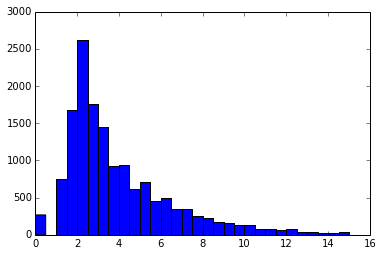

In [11]:
plot_basic_hist(df['Course_Workload_Rating'], 30, (0,15))

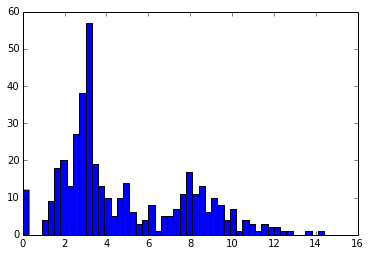

In [15]:
plot_workload_by_department(df, 'MATH')

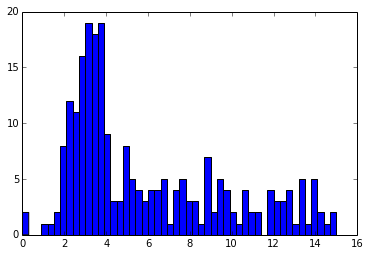

In [60]:
plot_workload_by_department(df, 'COMPSCI')

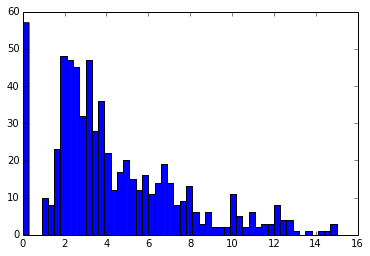

In [61]:
plot_workload_by_department(df, 'ECON')

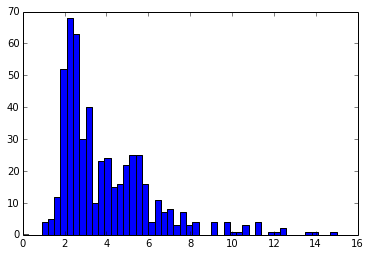

In [66]:
plot_workload_by_department(df, 'ENGLISH')

Preparing data for Enrollment Stuff

In [191]:
# USEFUL FUNCTIONS FOR THIS PART
def filter_nans(val):
    if val == [] or val == '[]':
        return 0
    else:
        return float(val)

In [192]:
df = pd.read_csv('data/final.csv').drop('Unnamed: 0', 1)

In [193]:
of_interest = df[['department1', 'year', 'term', 
                  'enrollment', 'name_key1', 'course_title']]
of_interest.loc[:, 'enrollment'] = (of_interest['enrollment']
                                     .apply(lambda x: filter_nans(x)))

/Library/Python/2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [194]:
top_depts = (of_interest.groupby('department1')['enrollment'].sum())
top_depts_list = top_depts.astype('int').sort_values()[-30:].index.tolist()

In [195]:
of_more_interest = (of_interest[of_interest['department1']
                                .isin(top_depts_list)])

In [63]:
of_more_interest.to_csv('enrollment.csv')

### For difficulty aggregate

In [156]:
relevant_cols = ['Course_Workload_Distribution', 
                 'Course_Overall_Distribution',
                 'Course_Overall_Respondents',
                 'Course_Workload_Rating',
                 'Course_Overall_Rating',
                 'Course_Workload_Respondents',
                 'enrollment', 
                 'name_key1',
                 'course_title', 
                 'year',
                 'term',
                 'department1']

In [157]:
CONVENTIONS = {
    'workload': {
        'distribution': 'Course_Workload_Distribution',
        'mean': 'Course_Workload_Rating',
        'intervals': [{'min': 0, 'max': 3},
                      {'min': 4, 'max': 7},
                      {'min': 8, 'max': 11},
                      {'min': 11, 'max': 14},
                      {'min': 11, 'max': 17}],
        'std_multiplier': 3,
        'respondents': 'Course_Workload_Respondents'
    },
    'overall': {
        'distribution': 'Course_Overall_Distribution',
        'mean': 'Course_Overall_Rating',
        'intervals': [{'min': 1, 'max': 1},
                      {'min': 2, 'max': 2},
                      {'min': 3, 'max': 3},
                      {'min': 4, 'max': 4},
                      {'min': 5, 'max': 5}],
        'std_multiplier': 1,
        'respondents': 'Course_Overall_Respondents'
    }
}

In [210]:
def get_ith_list_val(i, lst):
    if type(lst) == type(np.nan):
        return 0
    else:
        lst = ast.literal_eval(lst)
        if len(lst) == 0:
            return 0
        else:
            return lst[i]
        
def get_list_stat_nice(lst, func, std_multiplier):
    big_list = []
    for i in range(len(lst)):
        big_list += ([i] * lst[i])
    if len(big_list) == 1 and func == statistics.stdev: # Need 2+ data pts for variance
        return -1
    if func == statistics.stdev:
        return func(big_list) * std_multiplier
    else:
        return func(big_list)

def get_list_stat(lst, func, std_multiplier):
    if type(lst) == type(np.nan):
        return -1
    else:
        lst = ast.literal_eval(lst)
        if len(lst) == 0 or reduce(lambda x, y: x+y, lst) == 0:
            return -1
        else:
            return get_list_stat_nice(lst, func, std_multiplier)

def get_stat_score(statistic, desired, lst):
    if desired == 'median':
        intervals = CONVENTIONS[statistic]['intervals']
        m = get_list_stat(lst, statistics.median, 1)
        if m == -1:
            return np.nan
        if float(m).is_integer():
            i = int(m)
            return 0.5 * (intervals[i]['max'] + intervals[i]['min'])
        else:
            m = int(m-0.5)
            return 0.5 * (intervals[m]['max'] + intervals[m + 1]['min'])
    elif desired == 'stdev':
        std_multiplier = CONVENTIONS[statistic]['std_multiplier']
        return get_list_stat(lst, statistics.stdev, std_multiplier)

def add_distribution_data(in_df, statistics):
    in_df = in_df.copy()
    for statistic in statistics:
        column = CONVENTIONS[statistic]['distribution']
        for i in range(5):
            in_df[statistic + '_s' + str(i+1)] = (in_df[column]
                .apply(functools.partial(get_ith_list_val, i)))
    return in_df

def add_mean_data(in_df, statistics):
    in_df = in_df.copy()
    for statistic in statistics:
        in_df[statistic + '_mean'] = in_df[CONVENTIONS[statistic]['mean']]
    return in_df

def add_respondents_data(in_df, statistics):
    in_df = in_df.copy()
    for statistic in statistics:
        in_df[statistic + '_respondents'] = in_df[CONVENTIONS[statistic]['respondents']]
    return in_df

def add_instdev_data(in_df, statistics):
    in_df = in_df.copy()
    for statistic in statistics:
        column = CONVENTIONS[statistic]['distribution']
        in_df[statistic + '_instdev'] = (in_df[column]
                                        .apply(functools.partial(get_stat_score, statistic, 'stdev')))
    return in_df


def add_additional_data(in_df, statistics):
    in_df = in_df.copy()
    in_df = add_respondents_data(in_df, statistics)
    in_df = add_distribution_data(in_df, statistics)
    in_df = add_mean_data(in_df, statistics)
    in_df = add_instdev_data(in_df, statistics)
    return in_df

'''Computes weighted mean'''
def compute_grouped_mean(in_df, val_col, weight_col):
    in_df = in_df.copy()
    return weighted_mean(x=in_df[val_col], w=in_df[weight_col])

'''Computes the inter-group std (std of means weighted according to num respondants)'''
def compute_grouped_outstd(in_df, mean_col, weight_col):
    in_df = in_df.copy()
    return np.sqrt(weighted_cov(w=in_df[weight_col], x=in_df[mean_col], y=in_df[mean_col]))

def add_grouped_data(in_df, gb, statistics):
    in_df = in_df.copy()
    distribution_columns = []
    for statistic in statistics:
        for num in [1, 2, 3, 4, 5]:
            distribution_columns += [statistic + '_s' + str(num)]
    gp_df = in_df.groupby(gb)[distribution_columns].sum()
    for statistic in statistics:
        gp_df = (gp_df.join(in_df.groupby(gb)[[statistic + '_mean', statistic + '_respondents']]
                           .apply(compute_grouped_mean, statistic + '_mean', statistic + '_respondents')
                           .to_frame(statistic + '_mean'))
                 .join(in_df.groupby(gb)[[statistic + '_instdev', statistic + '_respondents']]
                       .apply(compute_grouped_mean, statistic + '_instdev', statistic + '_respondents')
                       .to_frame(statistic + '_instdev'))
                 .join(in_df.groupby(gb)[[statistic + '_mean', statistic + '_respondents']]
                       .apply(compute_grouped_outstd, statistic + '_mean', statistic + '_respondents')
                       .to_frame(statistic + '_outstdev')))
    return gp_df

def make_all_stats_for_year(in_df, year):
    in_df = in_df.copy()
    relevant_df = in_df[in_df.year == year][RELEVANT_COLS]
    basic_stats_df = add_additional_data(relevant_df, ['workload', 'overall'])
    grouped_stats_df = add_grouped_data(basic_stats_df, 'department1', ['workload', 'overall'])
    grouped_stats_df = grouped_stats_df[grouped_stats_df.index.isin(top_depts_list)]
    return grouped_stats_df

In [211]:
basic_stats_df = add_additional_data(relevant_df, ['workload', 'overall'])
grouped_stats_df = add_grouped_data(basic_stats_df, 'department1', ['workload', 'overall'])
grouped_stats_df = grouped_stats_df[grouped_stats_df.index.isin(top_depts_list)]

In [214]:
grouped_stats_df.sort_values('overall_outstdev')

,workload_s1,workload_s2,workload_s3,workload_s4,workload_s5,overall_s1,overall_s2,overall_s3,overall_s4,overall_s5,workload_mean,workload_instdev,workload_outstdev,overall_mean,overall_instdev,overall_outstdev
department1,,,,,,,,,,,,,,,,
SPANSH,1332,4042,999,112,50,51,207,972,2541,2987,3.191905,1.944804,1.579686,4.214117,0.795844,0.282742
ETHRSON,2055,3438,588,46,30,102,408,1379,2583,2024,2.847669,1.888124,1.224740,3.925062,0.903916,0.306533
CULTBLF,3270,4356,666,62,23,102,456,1722,3472,3096,2.468545,1.837499,1.053884,4.015269,0.863717,0.313039
PHYSCI,195,2167,1739,362,153,167,593,1511,1641,825,4.810962,2.368908,2.268167,3.500401,0.973573,0.333174
SOCWORLD,1606,3413,849,112,29,110,358,1245,2379,2204,2.816991,1.951843,1.156378,3.992122,0.895333,0.356579
SCILIVSY,1864,2815,523,56,29,138,378,1300,1980,1690,2.673917,2.025728,1.134484,3.850583,0.941988,0.371696
STAT,1302,5254,3712,956,822,231,847,2782,4712,4199,4.811647,2.269072,3.149624,3.927641,0.900646,0.383429
EXPOS,1015,6102,2275,311,134,134,582,1800,3756,3873,3.725099,2.041996,1.676108,4.049660,0.864011,0.390902
ENGLISH,852,4593,2105,373,150,74,189,926,2343,4896,3.755890,1.983221,1.989326,4.400688,0.701565,0.391545


## For Listing Within Department

This will allow the sorting of particular classes.

In [68]:
ranked = df[['term', 'year', 'name_key1', 'department1', 'enrollment', 'course_title', 'Course_Workload_Rating', 'Course_Overall_Rating']]
ranked['Course'] = ranked["name_key1"].map(str) + ': ' + ranked["course_title"]
ranked = ranked.drop(['name_key1', 'course_title'], 1)
ranked = ranked.rename(columns={'Course_Workload_Rating': 'Workload',
                                'Course_Overall_Rating': 'Overall',
                                'enrollment': 'Enrollment',
                                'department1': 'department'}).set_index('Course')
ranked.to_csv('data/ranked.csv')

/Library/Python/2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [69]:
ranked

,term,year,department,Enrollment,Workload,Overall
Course,,,,,,
AESTHINT 13: Cultural Agents,fall,2011,AESTHINT,59,1.5,3.7
AESTHINT 15: Elements of Rhetoric,fall,2011,AESTHINT,48,2.3,4.2
AESTHINT 24: First Nights: Five Performance Premieres,fall,2011,AESTHINT,111,1.5,3.9
"AESTHINT 26: Race, Gender, and Performance",fall,2011,AESTHINT,99,1.6,3.8
AESTHINT 30: Love In A Dead Language: Classical Indian Literature and Its Theorists,fall,2011,AESTHINT,29,2.0,4.3
AESTHINT 33: Ancient Fictions: The Ancient Novel in Context,fall,2011,AESTHINT,81,1.7,4.1
AESTHINT 35: Forms in Korean Cultural History,fall,2011,AESTHINT,9,1.6,3.9
AESTHINT 37: Introduction to the Bible in the Humanities and the Arts,fall,2011,AESTHINT,182,1.8,3.1
AESTHINT 38: The English Language as Literature,fall,2011,AESTHINT,16,1.6,4.1
